In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#build vocabulaty of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}

In [5]:
#build the dataset
block_size = 3 #context length: how many characters to look at to predict the next one?
X,Y = [],[]
for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop the first element and apend the new one

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

As we can see, the 'e' is encodded as 5. To encode the examples, we create embeddings.

In [8]:
#We create a 2 dimensional tensor of shape (n_words, block_size) containing the integer encoded characters
C = torch.randn((27,2)) #the random embedding layer
C[5]

tensor([-1.1406,  1.7067])

In [9]:
F.one_hot(torch.tensor(5), num_classes=27) #one hot encoding of the 5th character
#and if we do a dot product of the one hot encoding with the embedding matrix we get the embedding of the 5th character
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.1406,  1.7067])

i.e., we can index 5th row from C or we can treat "one-hot-encoding @ C" as 1st layer
So, we just use embedding tables and discard the one-hot encoding

In [10]:
#python indexing is powerful
print(C[5])
print('-'*4)
print(C[[5,6,7]]) #if we provide a list of indexes, we can retrieve mupltiple elements
print('-'*4)
print(C[[5,6,7,7,7]]) #indexing can retrieve mupltiple elements, and same element multiple times
print('-'*4)
print(C[torch.tensor([5,6,7])]) 
print('-'*4)
#index can also be 2D
#For example: X is 32x3, so we can pass it to C, embedding matrix directly to get the embeddings corresponging ...?
print(C[X].shape)
print(X[13,2])
print(C[X][13,2]) #----(1) also can be written as C[X[13,2]]
print(C[X[13,2]]) #----(1a)
print(C[1])       #----(2)
#(1) & (1a) is the same as (2) because X[13,2] = 1


tensor([-1.1406,  1.7067])
----
tensor([[-1.1406,  1.7067],
        [ 1.0376,  1.7113],
        [ 0.4232,  0.0789]])
----
tensor([[-1.1406,  1.7067],
        [ 1.0376,  1.7113],
        [ 0.4232,  0.0789],
        [ 0.4232,  0.0789],
        [ 0.4232,  0.0789]])
----
tensor([[-1.1406,  1.7067],
        [ 1.0376,  1.7113],
        [ 0.4232,  0.0789]])
----
torch.Size([32, 3, 2])
tensor(1)
tensor([1.8286, 0.7084])
tensor([1.8286, 0.7084])
tensor([1.8286, 0.7084])


In [11]:
#basically, our embedddnig is just
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [12]:
W1 = torch.randn((6,100)) #2 from each of 3 previous 'block_size' context characters
b1 = torch.randn(100) #biases for this layer



In [13]:
#but we can not do 
#emb @ W1 + b1 #since emb is 32x3x2 and W1 is 6x100
#so, we'll need to do something to make the shapes compatible
#we want to retrieve the three context character ebeddings and concatenate them
emb[:,0,:].shape #it plucks out the embeddings of the first character/word


torch.Size([32, 2])

In [14]:
#so, we do following
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape #concatenating the embeddings of the three context characters

torch.Size([32, 6])

In [15]:
torch.unbind(emb, 1) #this will give us a list of 3 tensors, each of shape 32x2, exactly equivalant to "[emb[:,0,:], emb[:,1,:], emb[:,2,:]]""makemore part 2.ipynb"


(tensor([[ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [-1.1406,  1.7067],
         [ 1.2426, -0.9235],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [-0.4959,  0.0249],
         [-0.9457,  1.2776],
         [ 0.7457,  0.0992],
         [ 0.6225,  1.2407],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [ 1.8286,  0.7084],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [ 0.7457,  0.0992],
         [ 0.0982, -1.6248],
         [ 1.8286,  0.7084],
         [ 0.5046,  0.0502],
         [-1.1406,  1.7067],
         [-0.9457,  1.2776],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [ 0.0982, -1.6248],
         [-0.4959,  0.0249],
         [-1.1105,  1.6384],
         [ 0.5265,  0.3940]]),
 tensor([[ 0.4319, -0.3574],
         [ 0.4319, -0.3574],
         [-1

In [16]:
#so, we do:
torch.cat(torch.unbind(emb, 1), 1) #slicing and concatenating the embeddings of the three context characters this way 
                                   #is more flecible than hardcoding the no. of context chars/words (3 above) as we did above
                                   

tensor([[ 0.4319, -0.3574,  0.4319, -0.3574,  0.4319, -0.3574],
        [ 0.4319, -0.3574,  0.4319, -0.3574, -1.1406,  1.7067],
        [ 0.4319, -0.3574, -1.1406,  1.7067,  1.2426, -0.9235],
        [-1.1406,  1.7067,  1.2426, -0.9235,  1.2426, -0.9235],
        [ 1.2426, -0.9235,  1.2426, -0.9235,  1.8286,  0.7084],
        [ 0.4319, -0.3574,  0.4319, -0.3574,  0.4319, -0.3574],
        [ 0.4319, -0.3574,  0.4319, -0.3574, -0.4959,  0.0249],
        [ 0.4319, -0.3574, -0.4959,  0.0249, -0.9457,  1.2776],
        [-0.4959,  0.0249, -0.9457,  1.2776,  0.7457,  0.0992],
        [-0.9457,  1.2776,  0.7457,  0.0992,  0.6225,  1.2407],
        [ 0.7457,  0.0992,  0.6225,  1.2407,  0.7457,  0.0992],
        [ 0.6225,  1.2407,  0.7457,  0.0992,  1.8286,  0.7084],
        [ 0.4319, -0.3574,  0.4319, -0.3574,  0.4319, -0.3574],
        [ 0.4319, -0.3574,  0.4319, -0.3574,  1.8286,  0.7084],
        [ 0.4319, -0.3574,  1.8286,  0.7084,  0.6225,  1.2407],
        [ 1.8286,  0.7084,  0.6225,  1.2

In [17]:
#we can also use .view() to do the same thing which is even more efficient
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [18]:
a.shape

torch.Size([18])

In [19]:
# a.view(3,2,3) or
# a.view(9,2) or
# a.view(2,9) or etc

In [20]:
#this is possible since pytorch stores the numbers in a simple 1D vector
a.storage()
#so, when we call .view(), no memory is copied, just the shape and stride information is changed

C:\Users\himan\AppData\Local\Temp\ipykernel_18300\4032053941.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [21]:
#So, now insteadd of "torch.cat(torch.unbind(emb, 1), 1) ", 
#we do:
# emb.view(32,6)

In [22]:
#so, the code becomes:
h = torch.tanh(emb.view(32,6) @ W1 + b1)
h.shape

#now, if we do emb.view(-1,6), then pytorch will automatically infer the first dimension to be 32, or whatebver is the size of the first dimension of emb
#so, the code becomes:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

#Caution about '+' operator broadcasting!
#we've
#32,100 #emb.view(-1,6) @ W1
#   100 #b1
#so, broadcasting will do:
#32,100
# 1,100 #i.e., add 1 more dimention to b1. And each row of b1 will be added to each row of the result of emb.view(-1,6) @ W1
#Here, correct thing would be happening, as same bias vector will be added to the rows

#torch.cat is inefficient since it creates new memories and new tensors



In [23]:
h.shape

torch.Size([32, 100])

In [25]:
W2 = torch.randn((100,27)) #27 is the no. of characters in our vocab, #100 is the no. of hidden units in previous layer
b2 = torch.randn(27) #biases for this layer


In [26]:
logits = h@W2 + b2 #output of W2 layer
logits.shape

torch.Size([32, 27])

In [27]:
counts = logits.exp() #to get fake counts
prob = counts / counts.sum(1, keepdims=True) #normalizing the counts to get probabilities
prob.shape

torch.Size([32, 27])

In [28]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [31]:
#Now, just like previous noteebook, we index each row and pluck out the probab assigned to next character as given in Y
#we've an iterator from 0 to 31 -> torch.arange(32)
prob[torch.arange(32), Y]  #iterators over the rows of prob and plucks out the probab assigned to next character as given in Y

tensor([9.8226e-07, 1.8257e-03, 5.3622e-06, 3.7332e-05, 2.3064e-16, 3.0600e-03,
        3.7274e-06, 3.1741e-12, 4.2422e-08, 5.5294e-11, 4.8401e-09, 2.6763e-12,
        1.8752e-06, 4.5004e-05, 1.1623e-05, 5.2608e-14, 8.6591e-10, 2.3419e-04,
        1.6275e-10, 9.2767e-13, 9.4700e-15, 2.2960e-11, 1.4364e-13, 6.7789e-07,
        4.0280e-11, 5.0272e-06, 9.5522e-09, 1.5012e-05, 9.4591e-07, 3.0820e-14,
        1.0558e-08, 5.7285e-13])

In [33]:
#these probablities of next characters should be nearer to 1, then the model is doing well
#so, we can take the log of these probabilities and average them up to get the loss, and then -ve it to get negative log likelihood
loss = -prob[torch.arange(32), Y].log().mean()
loss #we have to minimize this loss

tensor(19.1263)

In [ ]:
#Recap:

In [34]:
X.shape, Y.shape #dataset

(torch.Size([32, 3]), torch.Size([32]))

In [41]:
g = torch.Generator().manual_seed(2147483647) #for reproducibility
C = torch.randn((27,2), generator=g) #embedding layer

W1 = torch.randn((6,100), generator=g) #first layer
b1 = torch.randn(100, generator=g) #biases for first layer

W2 = torch.randn((100,27), generator=g) #second layer
b2 = torch.randn(27, generator=g) #biases for second layer

parameters = [C, W1, b1, W2, b2] #all the parameters

In [42]:
sum(p.nelement() for p in parameters) #total no. of parameters

3481

In [38]:
#Forward pass
emb = C[X] #embedding layer #32x3x2

h = torch.tanh(emb.view(-1,6) @ W1 + b1) #first layer #32x100

logits = h@W2 + b2 #output of W2 layer #32x27
# counts = logits.exp() #to get fake counts
# prob = counts / counts.sum(1, keepdims=True) #normalizing the counts to get probabilities
# loss = -prob[torch.arange(32), Y].log().mean() #loss
#instead of above manner of calculating loss, we can use F.cross_entropy() which does the same thing
loss = F.cross_entropy(logits, Y)
loss
#we use F.cross_entropy() 'cause:
#1. pytorch wont create new intermediate tensors, and instead clusters them and use fused kernels
#2. expressions of derivatives simplify which is used by pytorch
#3. under the hood, cross-entropy can be more numericaly more well behaved: for example, if logits have a high +ve value, then 
#   taking ann exp of it can run out of dynamic range of floating point values. Ex: logit has a 100, then e^100 is out of range
#   but cross_entropy internally subtracts the biggest number from logits, to offset it timestamp: @37:45
#   awesome explaination

#bakcward pass
for p in parameters:
    p.grad = None #setting gradients to 0 before each backward pass
loss.backward()

#update
for p in parameters:
    p.data += -0.1*p.grad #updating the parameters




tensor(17.7697)

In [43]:
for p in parameters:
    p.requires_grad = True #enabling gradients for all parameters

In [44]:
for _ in range(10):
    #Forward pass
    emb = C[X] #embedding layer #32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #first layer #32x100
    logits = h@W2 + b2 #output of W2 layer #32x27
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1*p.grad #updating the parameters

#since we only have 32 examples, and 3481 params, it is very easy to overfit the data and achieve low error rates
#so, we can use a larger dataset to train the model
# we still are not able to achieve 0 loss, since ... needs to predict a, o, i etc i.e. ... ko multiple things predict karni hai
# but jahan jahan unique combinations hain previous 3 characters ki, wahan near to 0 loss achieve kar rhe hain


17.76971435546875
13.656400680541992
11.298768997192383
9.4524564743042
7.984262466430664
6.891321182250977
6.100014686584473
5.452036380767822
4.898151874542236
4.414664268493652


In [58]:
#So let us do this for all words and not just 5
#build the dataset
block_size = 3 #context length: how many characters to look at to predict the next one?
X,Y = [],[]
for w in words: #all words
    
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop the first element and apend the new one

X = torch.tensor(X)
Y = torch.tensor(Y)

In [59]:
X.shape, Y.shape #dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [90]:
g = torch.Generator().manual_seed(2147483647) #for reproducibility
C = torch.randn((27,2), generator=g) #embedding layer

W1 = torch.randn((6,100), generator=g) #first layer
b1 = torch.randn(100, generator=g) #biases for first layer

W2 = torch.randn((100,27), generator=g) #second layer
b2 = torch.randn(27, generator=g) #biases for second layer

parameters = [C, W1, b1, W2, b2] #all the parameters

In [91]:
sum(p.nelement() for p in parameters) #total no. of parameters

3481

In [92]:
for p in parameters:
    p.requires_grad = True #enabling gradients for all parameters

In [63]:
for _ in range(100):
    
    #it'll be much faster in minibatches
    #minibatch construct
    ix = torch.randint(0,X.shape[0],(32,)) #randomly sample 32 numbers from 0 to 228146


    #Forward pass
    emb = C[X[ix]] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #first layer #32x100
    logits = h@W2 + b2 #output of W2 layer #32x27
    loss = F.cross_entropy(logits, Y[ix]) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1*p.grad #updating the parameters

#In Minibatches, the quality of gradients is not as good as in full batch, but it is much faster
#since it is better to make many steps with aproximate gradients than to make few steps with exact gradients

16.722684860229492
17.80501365661621
15.122965812683105
15.761963844299316
11.688470840454102
11.920717239379883
15.058136940002441
11.585692405700684
12.898177146911621
10.77206039428711
12.597578048706055
10.017439842224121
10.154825210571289
8.948321342468262
11.433053970336914
11.569074630737305
9.36916732788086
7.798447608947754
8.66457748413086
8.724126815795898
7.289283275604248
8.376447677612305
7.311673641204834
7.42368745803833
6.9834699630737305
7.075383186340332
7.5329084396362305
7.430334568023682
5.531008720397949
7.091148376464844
6.237879753112793
6.119830131530762
6.990893840789795
8.585159301757812
7.845841407775879
5.922115325927734
6.849554061889648
5.938353061676025
6.442837715148926
4.078384876251221
5.787971496582031
6.617045879364014
5.197267532348633
4.058233261108398
6.0693464279174805
5.1775665283203125
7.14966344833374
4.33341121673584
4.22559928894043
5.316624164581299
7.456387519836426
4.514888763427734
5.502017498016357
5.026523590087891
5.907541275024414

In [ ]:
#Above fwd and backward pass is being done for each of 228146 examples
#so, instead of passing each example individually, we can do this fwd and backward pass in batches
#we randomly sample from the examples and then pass them in batches
torch.randint(0, X.shape[0], (32,)) #generate numbers bw 0 and 228156, and randomly sample 32 numbers from the dataset
                                    #these are the indexes of the examples we'll use in the batch

In [64]:
#But, how to select proper learning rate?
#we can use torch.linspace() to generate a range of learning rates and then plot the loss vs learning rate
lre = torch.linspace(0.001, 1, 1000) #generate 1000 learning rates from 0.001 to 1 in a linear space
#but, linear space se better hai ki us intervel me exponentially placed ho
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre #convert the linearly spaced learning rates to exponentially spaced learning rates, 10^0 is 1
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [78]:
lre

tensor([-3.0000, -2.9970, -2.9940, -2.9910, -2.9880, -2.9850, -2.9820, -2.9790,
        -2.9760, -2.9730, -2.9700, -2.9670, -2.9640, -2.9610, -2.9580, -2.9550,
        -2.9520, -2.9489, -2.9459, -2.9429, -2.9399, -2.9369, -2.9339, -2.9309,
        -2.9279, -2.9249, -2.9219, -2.9189, -2.9159, -2.9129, -2.9099, -2.9069,
        -2.9039, -2.9009, -2.8979, -2.8949, -2.8919, -2.8889, -2.8859, -2.8829,
        -2.8799, -2.8769, -2.8739, -2.8709, -2.8679, -2.8649, -2.8619, -2.8589,
        -2.8559, -2.8529, -2.8498, -2.8468, -2.8438, -2.8408, -2.8378, -2.8348,
        -2.8318, -2.8288, -2.8258, -2.8228, -2.8198, -2.8168, -2.8138, -2.8108,
        -2.8078, -2.8048, -2.8018, -2.7988, -2.7958, -2.7928, -2.7898, -2.7868,
        -2.7838, -2.7808, -2.7778, -2.7748, -2.7718, -2.7688, -2.7658, -2.7628,
        -2.7598, -2.7568, -2.7538, -2.7508, -2.7477, -2.7447, -2.7417, -2.7387,
        -2.7357, -2.7327, -2.7297, -2.7267, -2.7237, -2.7207, -2.7177, -2.7147,
        -2.7117, -2.7087, -2.7057, -2.70

In [95]:
#self adaptive learning rate, low in the beginning and then high
lri = []
lossi = []
for i in range(10000):
    
    #it'll be much faster in minibatches
    #minibatch construct
    ix = torch.randint(0,X.shape[0],(32,)) #randomly sample 32 numbers from 0 to 228146


    #Forward pass
    emb = C[X[ix]] #embedding layer #First pick only ix indexes from X, and then based on X[ix], pick only X[ix] indexes from C #32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #first layer #32x100
    logits = h@W2 + b2 #output of W2 layer #32x27
    loss = F.cross_entropy(logits, Y[ix]) #ix also indexes from Y, so that we can calculate loss for only those 32 examples
    # print(loss.item())
    
    #bakcward pass
    for p in parameters:
        p.grad = None #setting gradients to 0 before each backward pass
    loss.backward()

    #update
    # lr = lrs[i]
    lr = 0.01 #in the later stages, we can use a still smaller learning rate, it'll be like learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
    
    #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())

2.176069498062134


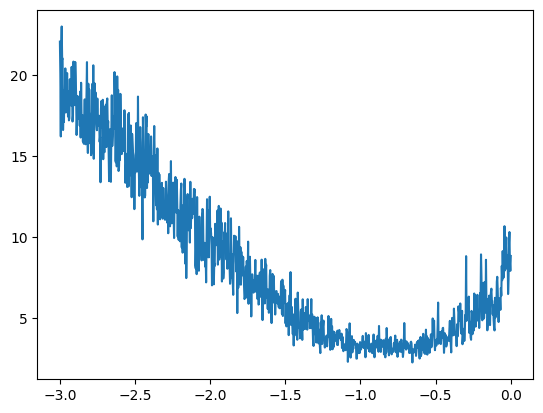

In [ ]:
plt.plot(lri, lossi) #i.e. lre around -1 is good , i.e 10^-1 = 0.1 is good learning rate